In [1]:
import RNA
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import calc_MCC, dict_dot_bracket, list_dot_bracket, forna_display, parse_rdat
from penalties import penalize_barriers, get_penalties, penalize_barriers_seq

In [2]:
shape_data = {}
rdat_files = sorted(['SRP_test/'+f for f in os.listdir('SRP_test') if 'rdat' in f])
#rdat_files = ['SRP_test/'+'SRPECLI_BZCN_0001.rdat.txt']
for r in rdat_files:
    shape_data[r.strip('SRP_test/SRPECLI_').strip('.rdat.txt')] = parse_rdat(r)

# Create dummy data with no constraints
shape_data['kinetic20'] = {}
shape_data['no_constraints'] = {}
for l in shape_data['BZCN_0001']:
    shape_data['kinetic20'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
    shape_data['no_constraints'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
#d = parse_rdat('SRP_test/SRPECLI_BZCN_0001.rdat.txt')
md = RNA.md()
md.temperature = 37

In [3]:
# Calculate folding pathways for each dataset
last_structure = ''
for n, d in shape_data.items():
    print(f'Working on {n}')
    for length in d.keys():
        subseq = d[length]['seq']
        reactivities = d[length]['react']
        # Shape-defined fold
        fc = RNA.fold_compound(subseq, md)
        if n not in ['no_constraints', 'kinetic20']:
            fc.sc_add_SHAPE_deigan(reactivities, 2.6, -0.8)
        if n == 'kinetic20':
            step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : 20
            }
            fc.sc_add_f(penalize_barriers)
            fc.sc_add_data(step_info)
        d[length]['mfe'] = fc.mfe()[0]
        last_structure = d[length]['mfe']


Working on BZCN_0001
Working on BZCN_0002
Working on BZCN_0003
Working on BZCN_0004
Working on DMS_0001
Working on DMS_0002
Working on DMS_0003
Working on kinetic20
Working on no_constraints


In [4]:
# also try drtransformer
print("Working on drtransformer")
shape_data['drtransformer'] = {}
name = 'SRP_drt'
#subprocess.run(['cat', 'SRP_test/SRP.fa', '|', 'DrTransformer' '--name', f'{name}', '--logfile'], shell=True, check=True) # this doesn't work for some reason

with open(f'SRP_test/{name}.log', 'r') as f:
    lines = f.readlines()

last_len = 0
start_len = min(list(shape_data['BZCN_0001'].keys()))
for l in lines:
    l = l.strip()
    if '#' in l:
        continue
    l = l.split()
    curr_len = int(l[0])
    if curr_len < start_len:
        continue
    if curr_len == last_len: # The MFE structure for each length if the first line with that length
        continue
    shape_data['drtransformer'][curr_len] = {
        'seq' : shape_data['BZCN_0001'][curr_len]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][curr_len]['seq']))],
        'mfe' : l[2]
    }
    last_len = curr_len

Working on drtransformer


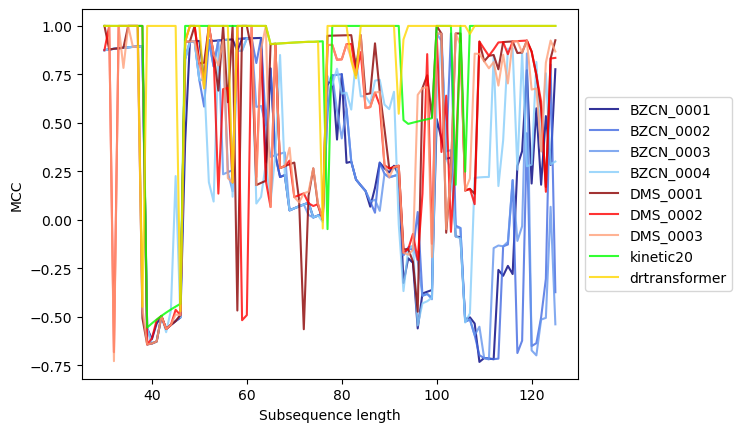

In [5]:
# Plot MCC at each length vs the no_constraints folding
# This at least tells us if if the kinetic method sees the same edges as the SHAPE data predicts
cols = {'BZCN_0001' : 'navy', 
        'BZCN_0002' : 'royalblue', 
        'BZCN_0003' : 'cornflowerblue', 
        'BZCN_0004' : 'lightskyblue', 
        'DMS_0001' : 'darkred', 
        'DMS_0002' : 'red', 
        'DMS_0003' : 'lightsalmon', 
        'kinetic20' : 'lime', 
        'drtransformer' : 'gold',
        'no_constraints' : 'black'}

fig, ax = plt.subplots()
for n, d in [it for it in list(shape_data.items()) if it[0] != 'no_constraints']:
#for n, d in [it for it in list(shape_data.items()) if it[0] != 'BZCN_0003']:
    x = list(d.keys()) # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data['no_constraints'][l]['mfe'])) for l in list(d.keys())]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

ax.set_xlabel('Subsequence length')
ax.set_ylabel('MCC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

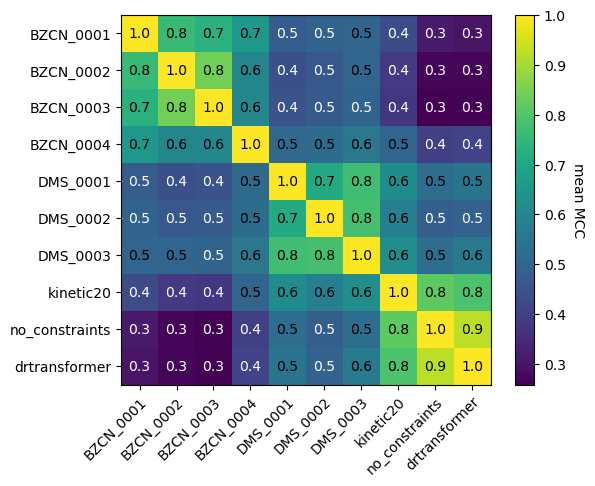

In [6]:
# plot mean MCC between different methods
fig, ax = plt.subplots()
corr = np.ones((len(shape_data.keys()), len(shape_data.keys())))
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(shape_data.items()):
        if i <= j:
            continue
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in list(d1.keys())])
        corr[i, j] = c
        corr[j, i] = c

im = ax.imshow(corr, origin='upper')
ax.set_yticks(np.arange(len(shape_data.keys())), list(shape_data.keys()))
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(corr.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(corr)):
    for j in range(len(corr)):
        kw.update(color=textcolors[int(corr[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(corr[i,j]), **kw)

plt.show()

In [7]:
# Let's try a single-value penalty sweep.  This isn't going to work, but its useful to see.

penalties = np.arange(5, 105, 5)
pred_at_pen = {}
for p in penalties:
    print("working on penalty =", p)
    pred_at_pen[p] = {}
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : int(p)
            }
        fc.sc_add_f(penalize_barriers)
        fc.sc_add_data(step_info)

        pred_at_pen[p][length] = fc.mfe()[0]
        last_structure = pred_at_pen[p][length]

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [8]:
penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_pen[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_pen[20].keys())])

In [9]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5	0.448	0.720	0.550
10	0.443	0.714	0.545
15	0.443	0.714	0.545
20	0.462	0.734	0.564
25	0.459	0.720	0.557
30	0.419	0.657	0.508
35	0.404	0.657	0.499
40	0.404	0.657	0.499
45	0.404	0.657	0.499
50	0.407	0.654	0.499
55	0.403	0.644	0.493
60	0.386	0.599	0.466
65	0.453	0.661	0.531
70	0.435	0.648	0.515
75	0.435	0.640	0.511
80	0.411	0.599	0.481
85	0.411	0.599	0.481
90	0.409	0.591	0.477
95	0.409	0.591	0.477
100	0.407	0.577	0.471

Best!
bzcn:	penalty=20 MCC=0.462
dms:	penalty=20 MCC=0.734
all:	penalty=20 MCC=0.564


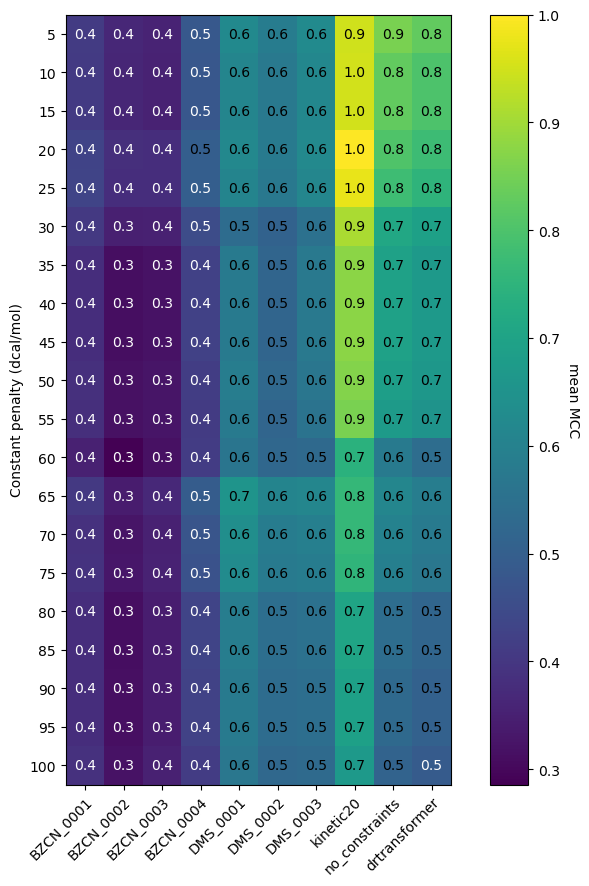

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(penalty_sweep[i, j]), **kw)

plt.show()

In [11]:
# Let's try the situation where it's dependent on the base pair broken

percents = np.arange(0.01, 0.262, 0.012)
pred_at_cent = {}
for p in percents:
    print("Working on percentage = {:.3f}".format(p), end='; ')
    pred_at_cent[p] = {}
    p_list = []
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        if last_structure != '':
            fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
            penalty_dict = get_penalties(last_structure, fc_last)
            p_list.extend([v for v in penalty_dict.values()])
        else:
            penalty_dict = {}
        step_info = {
            'last_dict' : dict_dot_bracket(last_structure),
            'penalty_dict' : penalty_dict,
            'penalty_percent' : p
            }
        fc.sc_add_f(penalize_barriers_seq)
        fc.sc_add_data(step_info)

        pred_at_cent[p][length] = fc.mfe()[0]
        last_structure = pred_at_cent[p][length]
    
    print("mean penalty = {:.0f}".format(np.mean(p_list)*p))

Working on percentage = 0.010; mean penalty = 4
Working on percentage = 0.022; mean penalty = 9
Working on percentage = 0.034; mean penalty = 14
Working on percentage = 0.046; mean penalty = 19
Working on percentage = 0.058; mean penalty = 24
Working on percentage = 0.070; mean penalty = 29
Working on percentage = 0.082; mean penalty = 34
Working on percentage = 0.094; mean penalty = 39
Working on percentage = 0.106; mean penalty = 44
Working on percentage = 0.118; mean penalty = 49
Working on percentage = 0.130; mean penalty = 54
Working on percentage = 0.142; mean penalty = 59
Working on percentage = 0.154; mean penalty = 64
Working on percentage = 0.166; mean penalty = 69
Working on percentage = 0.178; mean penalty = 74
Working on percentage = 0.190; mean penalty = 79
Working on percentage = 0.202; mean penalty = 84
Working on percentage = 0.214; mean penalty = 89
Working on percentage = 0.226; mean penalty = 94
Working on percentage = 0.238; mean penalty = 99
Working on percentage 

In [12]:
cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_cent[0.01].keys())])

In [13]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.448	0.720	0.550
0.022	0.449	0.719	0.550
0.034	0.468	0.736	0.569
0.046	0.468	0.736	0.569
0.058	0.462	0.734	0.564
0.070	0.459	0.720	0.557
0.082	0.456	0.710	0.551
0.094	0.404	0.657	0.499
0.106	0.404	0.657	0.499
0.118	0.407	0.654	0.500
0.130	0.407	0.654	0.500
0.142	0.407	0.654	0.500
0.154	0.386	0.599	0.466
0.166	0.453	0.661	0.531
0.178	0.449	0.659	0.528
0.190	0.449	0.650	0.525
0.202	0.432	0.617	0.501
0.214	0.432	0.617	0.501
0.226	0.432	0.617	0.501
0.238	0.432	0.617	0.501
0.250	0.432	0.609	0.498

Best!
bzcn:	penalty=0.034 MCC=0.468
dms:	penalty=0.034 MCC=0.736
all:	penalty=0.034 MCC=0.569


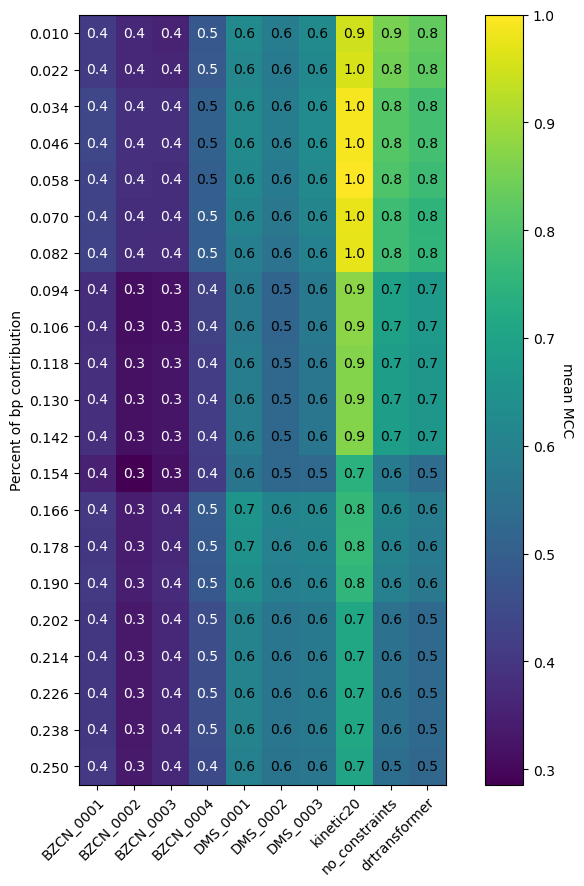

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(cent_sweep[i, j]), **kw)

plt.show()

In [15]:
#p = .5
#last_structure = ''
#for length in shape_data['kinetic20'].keys():
#    subseq = shape_data['kinetic20'][length]['seq']
#    fc = RNA.fold_compound(subseq, md)
#    fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
#    penalty_dict = get_penalties(last_structure, fc_last)
#    step_info = {
#            'last_dict' : dict_dot_bracket(last_structure),
#            'penalty_dict' : penalty_dict,
#            'penalty_percent' : p
#        }
#    fc.sc_add_f(penalize_barriers_seq)
#    fc.sc_add_data(step_info)
#
#    out = fc.mfe()
#
#    last_structure = out[0]
#    print(out)

In [16]:
(0.25-0.01)/20

0.012